In [2]:
import numpy as np
import h5py

from sklearn.metrics import accuracy_score

In [1]:
def load_OASIS():
    #with h5py.File('C:\\Users\\soh8020\\Desktop\\Alzheimer Data\\Alzheimer_64x64\\alz64_hdf5.h5', 'r') as hdf:
    with h5py.File('C:\\Users\\noush\\OneDrive\\Desktop\\ADNI\\OASIS_balanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('trainX'))
        trainY = np.array(G1.get('trainY'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('testX'))
        testY = np.array(G2.get('testY'))

        return trainX, trainY, testX, testY

In [3]:
def load_ADNI():
    #with h5py.File('C:\\Users\\soh8020\\Desktop\\Alzheimer Data\\Alzheimer_64x64\\alz64_hdf5.h5', 'r') as hdf:
    with h5py.File('C:\\Users\\noush\\OneDrive\\Desktop\ADNI\\ADNI_enhanced.h5', 'r') as hdf:

        G1 = hdf.get('Train Data')
        trainX = np.array(G1.get('x_train'))
        trainY = np.array(G1.get('y_train'))
        G2 = hdf.get('Test Data')
        testX = np.array(G2.get('x_test'))
        testY = np.array(G2.get('y_test'))

        return trainX, trainY, testX, testY

In [24]:
dataset = 'ADlNI'
# read the data which is also normalized.
if dataset == 'ADNI':
    x_train, y_train, x_test, y_test = load_ADNI()
else:
    x_train, y_train, x_test, y_test = load_OASIS()

print(x_train.shape, y_train.shape, x_test.shape,y_test.shape)

(8192, 176, 176) (8192,) (2560, 176, 176) (2560,)


In [25]:
# make it 3D (for VGG16)
if dataset == 'ADNI':
    x_train = np.repeat(x_train, 3, axis=3)
    x_test = np.repeat(x_test, 3, axis=3)
else:
    x_train = np.expand_dims(x_train, axis=-1)
    x_train = np.repeat(x_train, 3, axis=3)
    x_test = np.expand_dims(x_test, axis=-1)
    x_test = np.repeat(x_test, 3, axis=3)
print('x_train shape:', x_train.shape)

x_train shape: (8192, 176, 176, 3)


In [26]:
from tensorflow.keras.applications.vgg16 import VGG16
if dataset == 'ADNI':
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(218, 182, 3))
else:
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    
# Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

VGG_model.summary()  # Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 176, 176, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 176, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 176, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 88, 88, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 88, 88, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 88, 88, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 44, 44, 128)       0     

In [27]:
# Now, let us use features from convolutional network for KNN
print("extracting VGG16 features")
feature_extractor=VGG_model.predict(x_train)
print("reshaping features")
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
# print(feature_extractor.shape)
# print(features.shape)
X_Train = features #This is our X input to Logistic Regression.
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_Test = X_test_feature.reshape(X_test_feature.shape[0], -1)
print(X_Test.shape)
print(X_Train.shape)

extracting VGG16 features
reshaping features
(2560, 12800)
(8192, 12800)


In [28]:
print("Classifier-1:KNN")
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

classifiers = [
    ('KNN', KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)),
    ('SVM', svm.SVC(kernel='linear',C=1, probability = True)),
    ('Logistic Regression', LogisticRegression(solver = 'liblinear')),
]



Classifier-1:KNN


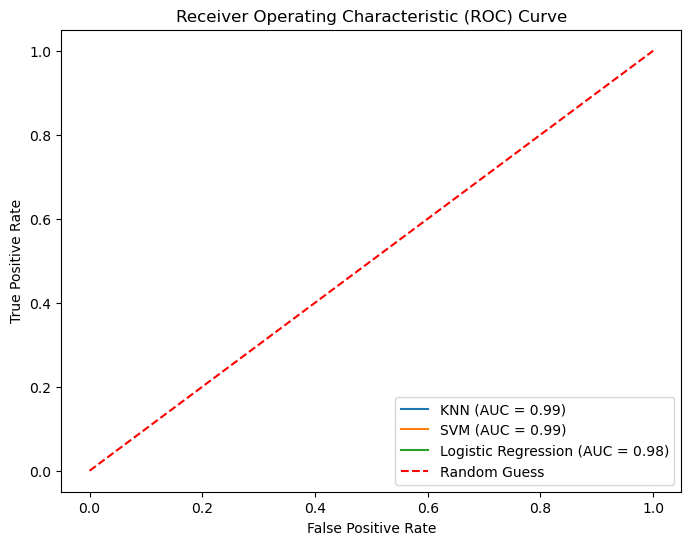

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix

from sklearn import metrics

plt.figure(figsize=(8, 6))
for clf_name, clf in classifiers:
    clf.fit(X_Train, y_train)
    y_pred_proba = clf.predict_proba(X_Test)

    prediction = clf.predict(X_Test)
    mcm = multilabel_confusion_matrix(y_true=y_test, y_pred=prediction, labels=[0,1,2,3], samplewise=False)
    tn = mcm[:,0,0]
    tp = mcm[:,1,1]
    fp = mcm[:,0,1]
    fn = mcm[:,1,0]
    specificity = tn/(tn+fp)
    sensitivity = tp/(tp+fn)

    tpr = np.mean(sensitivity)
    fpr = 1-np.mean(specificity)




    # fpr, tpr, _ = roc_curve(y_test, y_score)
    # roc_auc = auc(fpr, tpr)
    auc = metrics.roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(clf_name, auc))
# Add legend and labels
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()